In [365]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
from scipy.io import loadmat
import econtools 
import econtools.metrics as mt
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import itertools as it
import copy

# mine
import demand_discrete_choice.DiscreteChoice as dc
import importlib
importlib.reload(dc)

<module 'demand_discrete_choice.DiscreteChoice' from '/Users/jingyuanwang/GitHub/NU450_HW/450-1-HW2/demand_discrete_choice/DiscreteChoice.py'>

In [366]:
# ------------------------------------------------------------------------
# NOTE
# ------------------------------------------------------------------------
# Purpose: HW2 
# 
# Import data and stats
# 
#
# ------------------------------------------------------------------------

# Initialize file path

In [367]:
rootpath = '/Users/jingyuanwang/Dropbox/Course/ECON/IO/NU450/NU450_HW/450-1-HW2'
datapath = rootpath + '/' + 'data'
resultpath = rootpath + '/' + 'results'

# Parameters
Everything should be input in the following cell. 
All other cells are just operation and calculation.

In [368]:
# model parameters (true value)
true_parameters = {'beta': np.array([5,1,1]),
                   'alpha_0': 1,
                   'alpha_sigma':1,
                   'gamma': np.array([2,1,1])}

# import file names
matfiles = ['10markets3products', '100markets3products','100markets5products']
names = ['m10_prod3', 'm100_prod3', 'm100_prod5']

# Import Data

In [369]:
# 1 import
inputfiles = dict(zip(names, matfiles))
data = {}
for name, filename in inputfiles.items():
    file = datapath + '/Simulation Data/'+ filename
    data[name] = loadmat(file)


In [378]:
# 2. clean
sample = 'm100_prod3'
num_of_market = 100
num_of_prod = 3

df_product = (pd.DataFrame(np.concatenate( 
                          (data[sample]['x1'],
                           data[sample]['xi_all'],
                           data[sample]['w'], 
                           data[sample]['Z'],
                           data[sample]['eta']), axis = 1 ))
              .rename(columns = {0:'x1',1:'x2',2:'x3',3:'xi', 4:'w', 5:'z',6:'eta'}) )
df_product['price'] = np.reshape(data[sample]['P_opt'], (num_of_market*num_of_prod,1))

df_product['market_id'] = np.repeat(np.arange(num_of_market)[:,np.newaxis], num_of_prod, axis = 0)

df_product['product_id'] = (np.repeat(np.arange(num_of_prod)[:, np.newaxis], 
                                      num_of_market, axis=1)
                                .reshape((num_of_prod*num_of_market,1), order = 'F') )
product_ids = {'market_id':'market_id',
               'product_id':'product_id'}

# consumer
df_consumer = pd.DataFrame(data[sample]['alphas'].T, columns=[idx for idx in range(num_of_market) ])
df_consumer = df_consumer.stack().reset_index().rename(columns = {'level_0':'consumer_id', 
                                                                  'level_1':'market_id',
                                                                  0:'alpha'})


consumer_ids = {'market_id':'market_id',
               'consumer_id':'consumer_id'}


In [379]:
# 3. fit it into a class: discrete choice

#demand_m10_prod3 = dc.DiscreteChoice(df_consumer, consumer_ids, df_product, product_ids, true_parameters=true_parameters)
demand_m100_prod3 = dc.DiscreteChoice(df_consumer, consumer_ids, df_product, product_ids, true_parameters=true_parameters)
#demand_m100_prod5 = dc.DiscreteChoice(df_consumer, consumer_ids, df_product, product_ids, true_parameters=true_parameters)


# Simulate consumer choice and welfare

In [380]:
# Outline
# 1. simulate choice
# 2. compare with the given market share variable
# 3. save observables and final choice as a sample dataset. Make this a class
# 4. calculate welfare

In [381]:
product_attribute_observed = ['x1','x2','x3']
product_attribute_unobs = 'xi'
eps = 'eps_ijm'
price = 'price'
taste = demand_m10_prod3.true_par['beta']
price_sensitivity = 'alpha'

demand_m100_prod3.simulate_consumer_choice(product_attribute_observed, product_attribute_unobs, price,
                                    taste, price_sensitivity, eps)


,utility
market_id,
0,11207.672943
1,10423.319152
2,11213.009648
3,8773.785380
4,11621.378165
5,12372.054361
6,8929.625654
7,9081.418986
8,8578.703000


In [382]:
cost_attribute_observed = ['w', 'z']
cost_input_coeff = demand_m10_prod3.true_par['gamma']
error_term = 'eta'

demand_m100_prod3.simulate_firm_profit(cost_attribute_observed, cost_input_coeff, error_term)

,total_profit
product_id,
0,11514.869246
1,44636.538761
2,36165.045748


# Plot

In [391]:
def hist_and_kerneldensity(variable_series, var_label):
    # Figure parameters
    area = np.pi*3
    #filename = figpath + '/' + figname + '.png'

    # Plot
    plt.figure()
    plt.hist(variable_series, density = True, bins =16 )
    variable_series.plot.kde()
    
    plt.xlabel(var_label)
    max_value = max(variable_series)
    plt.xlim(0,max_value)
    #plt.savefig(filename)
    plt.show()

price:

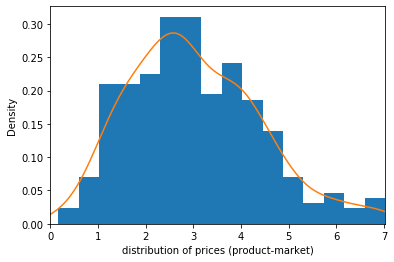

In [392]:
demand_sys = demand_m100_prod3
hist_and_kerneldensity(demand_sys.products['price'], var_label = 'distribution of prices (product-market)')

utility, welfare, and profit

------ Welfare ------
Welfare distribution for all markets:


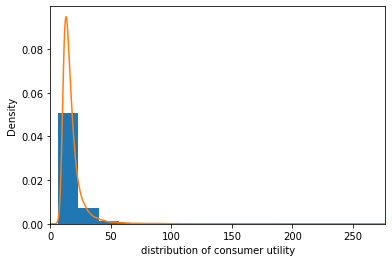

Welfare distribution in market 7


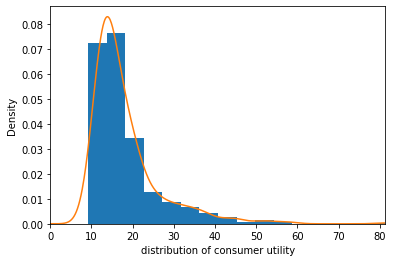

------ Profit ------
Profit distribution for all firms across all markets:


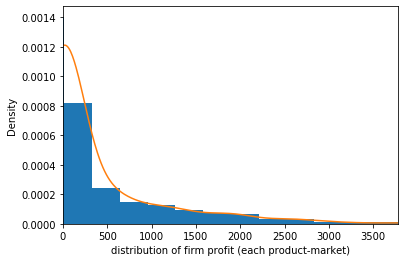

Profit distribution for firm 2 across all markets:


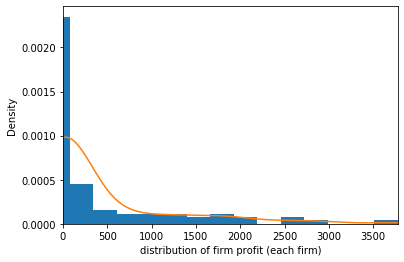

In [393]:
demand_sys = demand_m100_prod3

# one specific market
market = 7
firm = 2

print('------ Welfare ------')
print('Welfare distribution for all markets:')
hist_and_kerneldensity(demand_sys.consumers['utility'], var_label = 'distribution of consumer utility')


print('Welfare distribution in market {}'.format(market))
hist_and_kerneldensity(demand_sys.consumers.loc[demand_sys.consumers['market_id']==market, 'utility'],
                      var_label = 'distribution of consumer utility')

print('------ Profit ------')
print('Profit distribution for all firms across all markets:')
hist_and_kerneldensity(demand_sys.products['profit_jm'], 
                       var_label = 'distribution of firm profit (each product-market)')

print('Profit distribution for firm {} across all markets:'.format(firm))
hist_and_kerneldensity(demand_sys.products.loc[demand_sys.products['product_id'] == firm, 'profit_jm'], 
                       var_label = 'distribution of firm profit (each firm)')

# Estimation: Demand side instrument

In [179]:
num_of_market = max(len(df_product[consumer_ids['market_id']].unique()),  
                            len(df_product[product_ids['market_id']].unique()) )

In [185]:
max_num_of_consumer_withinmarket = df_consumer[consumer_ids].groupby(consumer_ids['market_id']).count().max()
max_num_of_prod_withinmarket = df_product[product_ids].groupby(product_ids['market_id']).count().max()

In [187]:
max_num_of_prod_withinmarket

product_id    3
dtype: int64

In [170]:
df_panel = pd.merge(panel_index, df_product, 
                 how= 'right',
                 left_on = [ panel_ids[key] for key in ('market_id','product_id')],
                 right_on =  list(product_ids.values()) )

In [174]:
df_panel.iloc[0:500,]

In [175]:
df_panel.sort_index(inplace = True)

In [ ]:
demand_m10_prod3.consumer_product.apply( lambda x: x+y, axis)

In [ ]:
df['']= demand_m10_prod3.consumer_product.head().apply(lambda row : row.x1 + row.x2, axis=1)

In [ ]:
# Outline
# 1. simulate choice
# 2. compare with the given market share variable
# 3. save observables and final choice as a sample dataset. Make this a class
# 4. calculate welfare

In [ ]:
#1. answer questions

In [ ]:
#2. estimate delta and xi, compare with real data